# Explanation of the steps performed for loading the data sets into HDFS.

The first step was to download the data required from the https://www.gutenberg.org/browse/languages/ website. This step was implemented in a python scrapper script as seen below.  Four langauages were picked, those were Spanish, German, Italian and French. The script will download less than 50 books for each language, althought this threshold could be higher if needed. Four directory are created for the four languages, also some sanity testing, the data set is ready for Hadoop. 

In [ ]:
import requests
from bs4 import BeautifulSoup
import os
from tqdm import tqdm

def download_file(url, folder):
    local_filename = url.split('/')[-1][:-6]
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        print("saving", folder + "/" + local_filename)
        with open(folder + "/" + local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=None):
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                if chunk:
                    f.write(chunk)
    return local_filename


languages = ["es", "de", "it", "fr"]

for language in languages:
    os.system("mkdir " + language)
    url = 'https://www.gutenberg.org/browse/languages/' + language

    # Connect to the URL
    response = requests.get(url)

    # Parse HTML and save to BeautifulSoup object¶
    soup = BeautifulSoup(response.text, "html.parser")

    end = False
    count = 1
    for one_a_tag in tqdm(soup.findAll('a')):  # 'a' tags are for links
        if end:
            break
        if 'href' in one_a_tag.attrs:
            if one_a_tag.attrs['href'].startswith("/ebooks"):
                print(one_a_tag.attrs['href'])
                link_txt = 'https://www.gutenberg.org' + one_a_tag.attrs['href'] + ".txt.utf-8"
                print(link_txt)
                response = requests.get(link_txt)
                if response.status_code != 200:
                    print("NOT A LINK")
                else:
                    link = 'https://www.gutenberg.org' + one_a_tag.attrs['href']
                    r = requests.get(link)
                    trs = BeautifulSoup(r.text, "html.parser").findAll('tr')
                    count_langs = 0
                    for tr in trs: # make sure we don't have a book with multiple languuages
                        if 'itemprop' in tr.attrs:
                            if tr.attrs['itemprop'] == "inLanguage":
                                count_langs += 1
                    print("count_langs:", count_langs)
                    if count_langs < 2:
                        count += 1
                        print("Total (so far):", count)
                        if count > 50:
                            end = True
                        print(download_file(link_txt, language))
    print("Total:", count)


## Create Hadoop cluster container using Docker

The next step is to get the data onto the Hadoop Distributed Filesystem. In order to build a hadoop one node cluster, I used Docker which allows for building OS level virtualized containers. The steps to complete this are given below:

1. Get the repository https://github.com/rancavil/hadoop-single-node-cluster
2. build the docker image
3. run it to get a container for the one node hadoop cluster and then make some minor modifcations to set up the web interfaces and to allow java code to be compiled, as seen below.

In [ ]:
# based on idea from:
https://medium.com/analytics-vidhya/hadoop-single-node-cluster-on-docker-e88c3d09a256 

# which uses files from this github repo:
https://github.com/rancavil/hadoop-single-node-cluster 
    
docker build -t hadoop .
docker run -it --name myhadoop -p 9864:9864 -p 9870:9870 -p 8088:8088 --hostname localhost hadoop
docker exec -it myhadoop bash            
    
# build Docker image
http://localhost:9864/ 
http://localhost:9870/ 
http://localhost:8088/ 

        
 
# get lesson example data
wget -q https://secureservercdn.net/160.153.137.210/umw.129.myftpupload.com/wp-content/uploads/2021/02/shakespeare.tar.gz && tar zxvf shakespeare.tar.gz  && rm shakespeare.tar.gz 

cat shakespeare/poems  | wc -l 

hdfs dfs -mkdir /user 
hdfs dfs -mkdir /user/hduser 
hdfs dfs -mkdir shakespeare  
hadoop fs -put shakespeare shakespeare  
hdfs dfs -ls 
hadoop fs -cat shakespeare/shakespeare/poems 

 
# setup with java class paths
echo $CLASSPATH 

echo `hadoop classpath`  

/home/hduser/hadoop-3.3.0/etc/hadoop:/home/hduser/hadoop-3.3.0/share/hadoop/common/lib/*:/home/hduser/hadoop-3.3.0/share/hadoop/common/*:/home/hduser/hadoop-3.3.0/share/hadoop/hdfs:/home/hduser/hadoop-3.3.0/share/hadoop/hdfs/lib/*:/home/hduser/hadoop-3.3.0/share/hadoop/hdfs/*:/home/hduser/hadoop-3.3.0/share/hadoop/mapreduce/*:/home/hduser/hadoop-3.3.0/share/hadoop/yarn:/home/hduser/hadoop-3.3.0/share/hadoop/yarn/lib/*:/home/hduser/hadoop-3.3.0/share/hadoop/yarn/* 


export CLASSPATH=`hadoop classpath`
echo $CLASSPATH 
export JAVA_HOME=/usr/lib/jvm/java-1.8.0-openjdk-amd64 
export PATH=${JAVA_HOME}/bin:${PATH} 
export HADOOP_CLASSPATH=${JAVA_HOME}/lib/tools.jar 

# to build:
javac WordCount.java 
jar cvf WordCount.jar * 


# some changes to get the jobs history browser working:

hduser@localhost:~$ cat /home/hduser/hadoop-3.3.0/etc/hadoop/mapred-site.xml 
<?xml version="1.0"?> 
<?xml-stylesheet type="text/xsl" href="configuration.xsl"?> 
<!-- 
  Licensed under the Apache License, Version 2.0 (the "License"); 
  you may not use this file except in compliance with the License. 
  You may obtain a copy of the License at 
    http://www.apache.org/licenses/LICENSE-2.0 
  Unless required by applicable law or agreed to in writing, software 
  distributed under the License is distributed on an "AS IS" BASIS, 
  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. 
  See the License for the specific language governing permissions and 
  limitations under the License. See accompanying LICENSE file. 
--> 
<!-- Put site-specific property overrides in this file. --> 
<configuration> 
<property> 
  <name> mapreduce.framework.name</name> 
  <value>yarn</value> 
</property> 
</configuration> 

# and also:

$ cat /home/hduser/hadoop-3.3.0/etc/hadoop/hdfs-site.xml
<?xml version="1.0" encoding="UTF-8"?>
<?xml-stylesheet type="text/xsl" href="configuration.xsl"?>
<!--
  Licensed under the Apache License, Version 2.0 (the "License");
  you may not use this file except in compliance with the License.
  You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

  Unless required by applicable law or agreed to in writing, software
  distributed under the License is distributed on an "AS IS" BASIS,
  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
  See the License for the specific language governing permissions and
  limitations under the License. See accompanying LICENSE file.
-->

<!-- Put site-specific property overrides in this file. -->

<configuration>
    <property>
        <name>dfs.replication</name>
        <value>1</value>
    </property>

    <property>
        <name>dfs.permissions</name>
        <value>false</value>
</property>
<property>
    <name>dfs.webhdfs.enabled</name>
    <value>true</value>
</property>
</configuration>

hadoop dfsadmin -safemode leave 
mr-jobhistory-daemon.sh start historyserver
 
http://172.17.0.2:19888/jobhistory/app 

The next step is copy the dataset to the hadoop file system, this was done by firstly copying the files to the container which is running hadoop and then using "put" to copy the local files to HDFS.

In [ ]:
hduser@localhost:~$ hdfs dfs -ls gutenberg/
Found 4 items
drwxr-xr-x   - hduser supergroup          0 2022-02-20 23:16 gutenberg/de
drwxr-xr-x   - hduser supergroup          0 2022-02-18 20:03 gutenberg/es
drwxr-xr-x   - hduser supergroup          0 2022-02-18 20:03 gutenberg/fr
drwxr-xr-x   - hduser supergroup          0 2022-02-18 20:03 gutenberg/it

# Design

![Whiteboard.png](Whiteboard.png)

The figure above shows the architecture of the Hadoop process to count the frequency of letter in the books provided by the gutenburg online library. The process uses two "ControlledJob" objects to execute two MapReduce jobs. These two jobs are named "Job0" and "Job1".

In "Job0", the input data is firstly ingested by the 1st "ControlledJob" which takes the input files and sets up 196 "Mapper" jobs to remove the non letter characters and pass the results to another chained "Mapper" which adds the Language as a key from the directory path, for example "es", "it" etc. 

The output from these 196 jobs is input to a single Reducer job where all lines are sorted by key (which is the language). This output is then written to disk to a temporary HDFS directory. 

In "Job1", the data is read from the temporary HDFS file and ingested by the "Job1Mapper", this "Mapper" is designed to break up the lines into letters and to create counters, the counters will count the total letters seen for each language. This Mapper will also output a value of "1" for each letter seen, so that the combiner and reducer can merge them together and count the number of each letter for each language. 

In the next step in "Job1", the data streams are again partitioned and sorted for the "Reducer". The "Reducer" will then count the total counts for each letter and divide that number by the total number of letters seen. This total number of letters seen is a counter which was created in the "Mapper". 

The final output from the process is then 4 individual files, each of which is a seperate tab separated file which contains one language, all the letters plus the frequency. The following is an exmaple of the "it" output:

An example of the output of each sub-stage(i.e. mapper and reducer function) is included in the code.

In [ ]:
it	A	0.002279
it	B	0.000830
it	C	0.002045
it	D	0.001101
it	E	0.001521
it	F	0.000810
it	G	0.001138
it	H	0.000182
it	I	0.002703
it	J	0.000072

The counters for each partition are show below:

![counters.png](counters.png)

I used some advanced featues of Hadoop in order to complete this process, The following is a short list of those features.



## JobControl

Used a "JobControl" class to allow for "ControlledJob" jobs to be set up and allow for one jobs to be dependent on another. This feature also allow mutliple jobs to be run side by side, however this was not useful for this task. 

## ChainMapper

Used a "ChainMapper" in Job0 to divide up the two "Mapper" functions, the first "Mapper" is removing characters from the lines and second is adding the language key to the "ChainMapper" output. 

## Partitioner

A "Partitioner" is used to split the stream of data into the individual languages so that the following reduce functions can work in parellel to produce the output in a shorter time. 

The process was kicked off by a bash script. This script clears up the previous output files, compiles the java files and produces a jar so that the hadoop job can be executed on the nodes. Below is the content of this script:

In [ ]:
set -x
set -e

hadoop fs -rm -r /user/hduser/myOutput  || true
hadoop fs -rm -r /user/hduser/myOutput-LetterFrequency-tmp || true
hadoop fs -rm -r /user/hduser/myOutput-LetterFrequency-tmp1 || true
javac *java 
jar cvf wc.jar  *class
rm *class
hadoop jar wc.jar LetterFrequency gutenberg/* myOutput

hdfs dfs -cat myOutput/part-r-00000 | head | grep fr || true
hdfs dfs -cat myOutput/part-r-00001 | head | grep de || true
hdfs dfs -cat myOutput/part-r-00002 | head | grep es || true
hdfs dfs -cat myOutput/part-r-00003 | head | grep it || true

Runs to process all gutenburg books located on HDFS, take on average around 8 minutes, as shown in the index.

# charts

Using the output files from the MapReduce process, The following section shows how those output files are visualised aswell as a comparison with the value seen on https://en.wikipedia.org/wiki/Letter_frequency. 

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'â', 'á', 'å', 'ä', 'ã', 'ą', 'æ', 'œ', 'ç', 'ĉ', 'ć', 'č', 'ď', 'ð', 'è', 'é', 'ê', 'ë', 'ę', 'ě', 'ĝ', 'ğ', 'ĥ', 'î', 'ì', 'í', 'ï', 'ı', 'ĵ', 'ł', 'ľ', 'ñ', 'ń', 'ň', 'ò', 'ö', 'ô', 'ó', 'õ', 'ø', 'ř', 'ŝ', 'ş', 'ś', 'š', 'ß', 'ť', 'þ', 'ù', 'ú', 'û', 'ŭ', 'ü', 'ů', 'ý', 'ź', 'ż', 'ž']


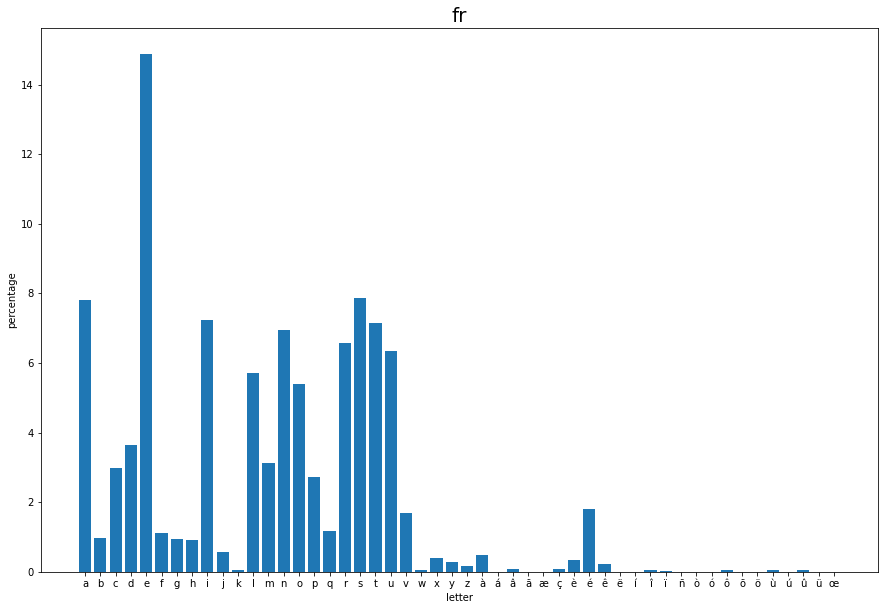

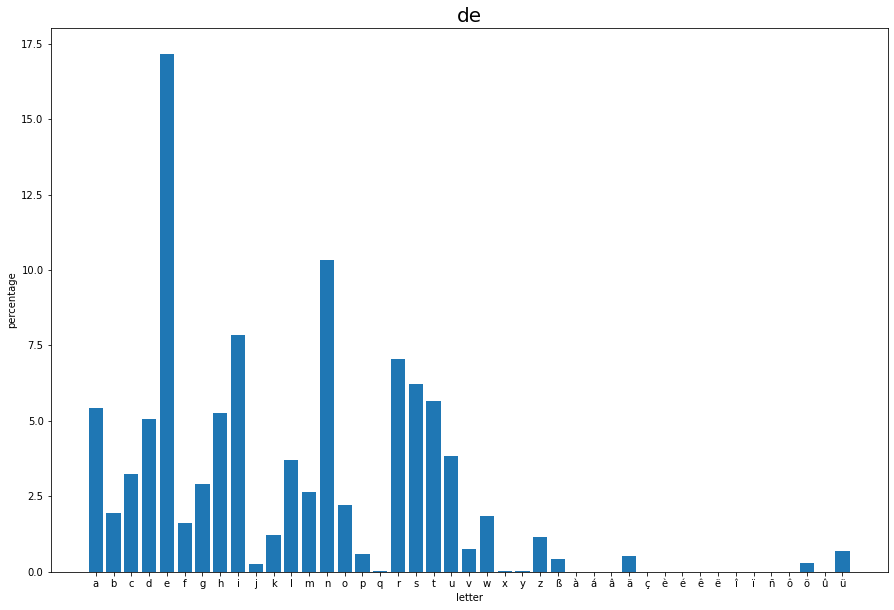

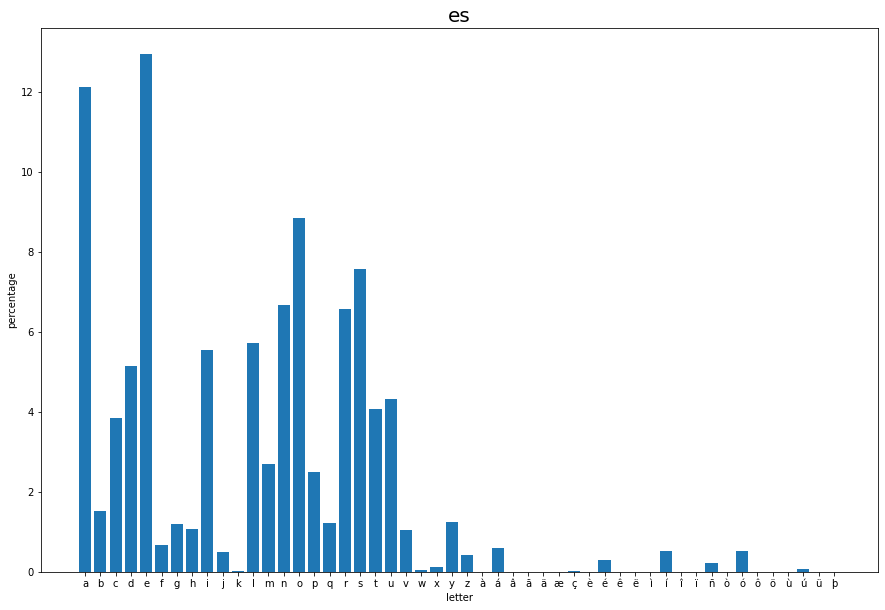

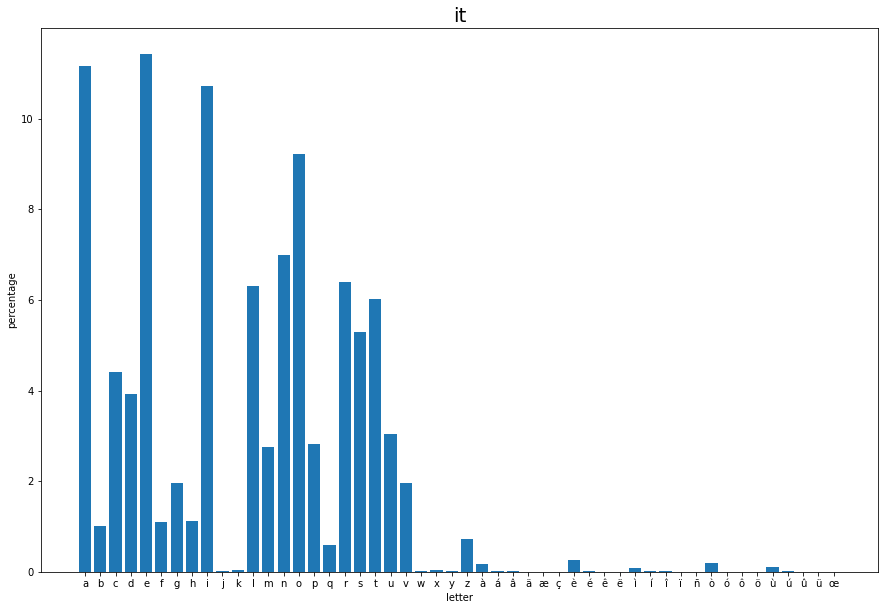

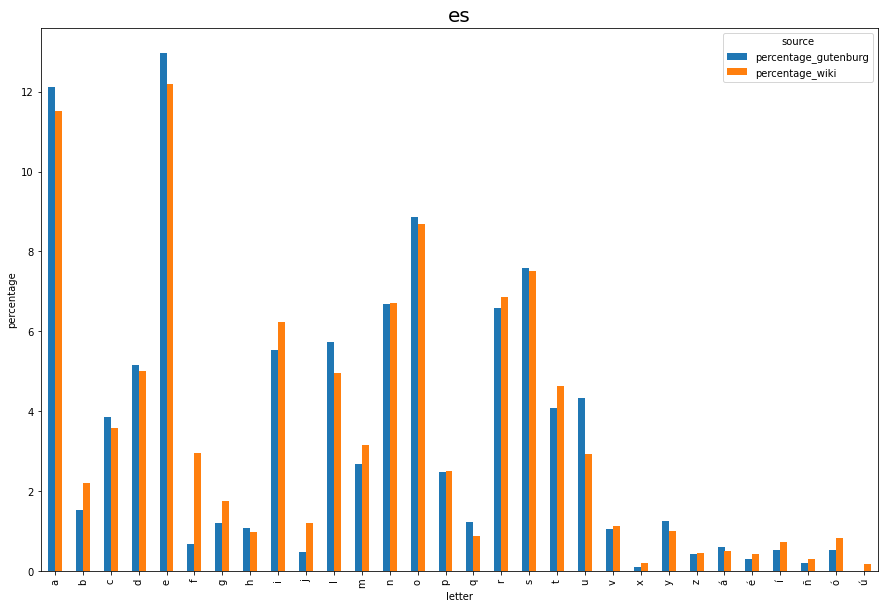

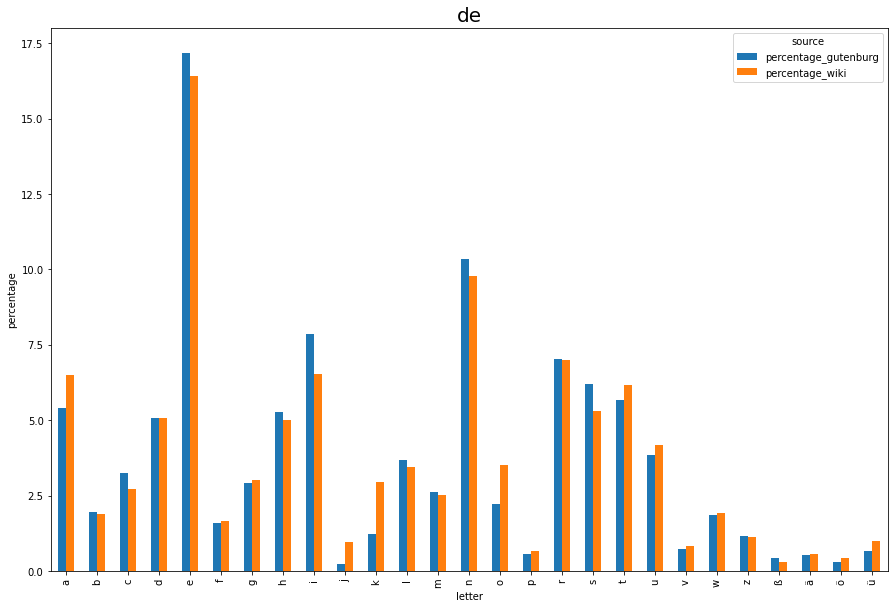

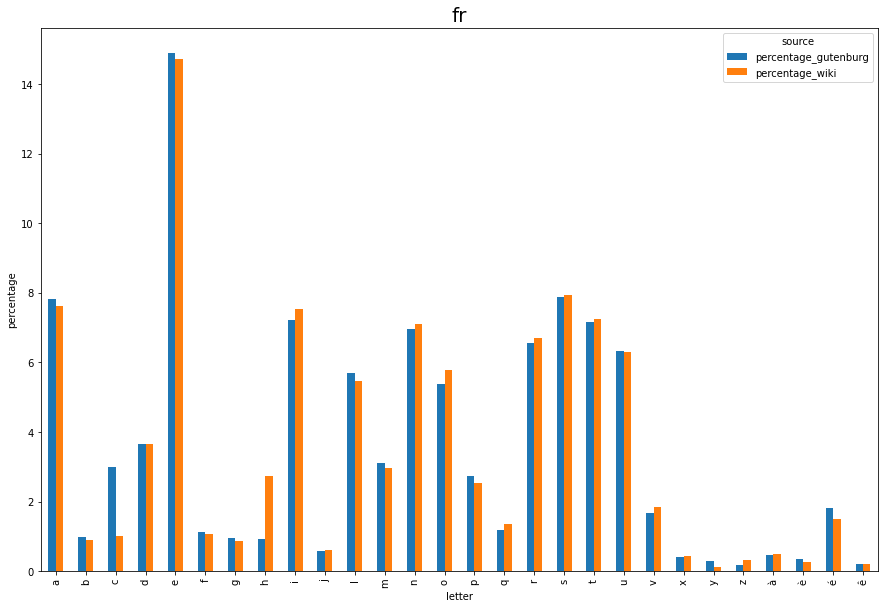

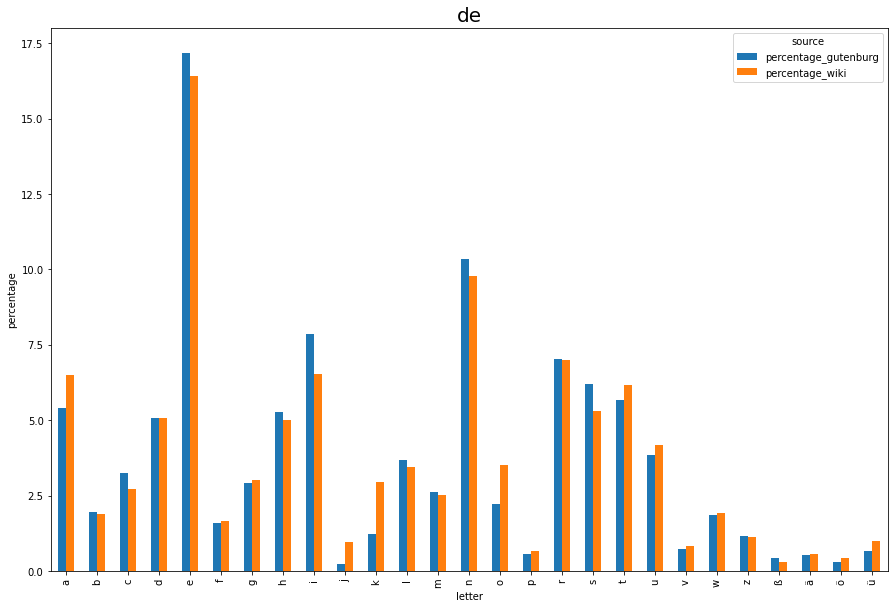

In [11]:
#!/usr/bin/env python3
# Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import subprocess
from io import StringIO
import requests
from bs4 import BeautifulSoup

def get_wiki_data():
    URL = "https://en.wikipedia.org/wiki/Letter_frequency"
    
    content = requests.get(URL).text
    # print(res)
    soup = BeautifulSoup(content, 'html.parser')
    # tables = soup.findAll("table", class_="wikitable sortable jquery-tablesorter")
    tables = soup.findAll("table",{"class":"wikitable sortable"})
    
    for i, table in enumerate(tables):
        headings = [th.get_text().strip() for th in table.find("tr").find_all("th")]     
        if table.findParent("table") is None:
            datasets = []
            for row in table.find_all("tr")[1:]:
                dataset = dict(zip(headings, (td.get_text().strip().replace("%","").replace("~","").replace(")","").replace("(","") for td in row.find_all("td"))))
                datasets.append(dataset)
    
    df = pd.DataFrame(datasets)
    df = df.astype({'French[21]':float, 'Spanish[23]':float, 'Italian[26]':float, 'German[22]':float})
    df = df.filter(['Letter','French[21]', 'Spanish[23]', 'Italian[26]', 'German[22]'])
    print(df['Letter'].tolist())
    df.rename(columns={'Letter':'letter','French[21]': 'fr', 'Spanish[23]': 'es', 'Italian[26]': 'it', 'German[22]': 'de'}, inplace=True)
    return df


def retrieve_df(hf):
    """Get the data stored on HDFS at the arguments location"""
    cmd = "docker exec myhadoop hdfs dfs -cat myOutput/{}".format(hf)
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
    out, err = p.communicate()
    DATA = StringIO(out.decode())
    df = pd.read_csv(DATA, sep="\t", names=["language", "letter", "percentage"])
    return df




def show_chart(df):
    """Create a bar chart of percentage vs letter"""
    fig = plt.figure(figsize=(15,10))

    ax = fig.add_subplot(111)
    ax.set_title(df["language"].iloc[0], fontsize=20)
    height = df["percentage"]
    bars = df["letter"]
    y_pos = np.arange(len(bars))
    ax.bar(y_pos, height)
    plt.xticks(y_pos, bars)
    plt.xlabel("letter")
    plt.ylabel("percentage")
    plt.show()


wikidf = get_wiki_data()
hadoop_files = ["part-r-00000","part-r-00001","part-r-00002","part-r-00003"]
frames = []
for hf in hadoop_files:
    df = retrieve_df(hf)
    show_chart(df)
    frames.append(df)

resultdf = pd.concat(frames)
wikimeltdf = pd.melt(wikidf, id_vars=['letter'], value_vars=['fr','es','it','de'],
                   var_name='language', value_name='percentage')

allmergedf = wikimeltdf.merge(resultdf, on = ['letter','language'], how = 'left', suffixes=('_wiki', '_gutenburg'))
alldf = pd.melt(allmergedf, id_vars=['letter','language'], value_vars=['percentage_wiki','percentage_gutenburg'],
                   var_name='source', value_name='percentage')

def source_chart(alldf, lang):
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    ax.set_title(lang, fontsize=20)
    df = (alldf
          .query('language == "{}"'.format(lang))
          .query('percentage > 0.1')
         )
    df.pivot("letter", "source", "percentage").plot(kind='bar', ax=ax)
    plt.xlabel("letter")
    plt.ylabel("percentage")
    plt.show()

source_chart(alldf, "es")
source_chart(alldf, "de")
source_chart(alldf, "fr")
source_chart(alldf, "de")

## Discussion

The charts produced in the final sectrion show that the results from the MapReduce job do a good job at estimating the letter frequency for each language when compared to the results from https://en.wikipedia.org/wiki/Letter_frequency. 
Some noticiable differences are "f" in Spanish, "c" in French and "h" in French as seen below. Only 8 letters across the 4 languages show a difference of more than 1%. That's 8 out of 340 letters(2.3%).
The result could be improved by increasing the number of books that are soruced from the gutenburg website which had a threshold of 50 at the beginning of this report.  

In [15]:
allmergedf['difference'] = abs(allmergedf['percentage_wiki'] - allmergedf['percentage_gutenburg'])
allmergedf.sort_values('difference', ascending=False).set_index('letter').head(10)

,language,percentage_wiki,percentage_gutenburg,difference
letter,,,,
f,es,2.948,0.675,2.273
c,fr,1.001,2.995,1.994
h,fr,2.739,0.923,1.816
k,de,2.957,1.231,1.726
u,es,2.927,4.324,1.397
i,de,6.550,7.854,1.304
o,de,3.511,2.223,1.288
a,de,6.516,5.421,1.095
s,de,5.320,6.214,0.894


# Appendix 

## output from MapReduce job (script run.sh included in attached zip)

In [ ]:
hduser@localhost:~/letterfrequency$ time bash run.sh 
+ set -e
+ hadoop fs -rm -r /user/hduser/myOutput
Deleted /user/hduser/myOutput
+ hadoop fs -rm -r /user/hduser/myOutput-LetterFrequency-tmp
Deleted /user/hduser/myOutput-LetterFrequency-tmp
+ hadoop fs -rm -r /user/hduser/myOutput-LetterFrequency-tmp1
rm: `/user/hduser/myOutput-LetterFrequency-tmp1': No such file or directory
+ true
+ javac -encoding UTF8 Job0AddLangMapper.java Job0Mapper.java Job0Partitioner.java Job1Combiner.java Job1Mapper.java Job1Partitioner.java Job1Reducer.java LetterFrequency.java TextPair.java
+ jar cvf wc.jar Job0AddLangMapper.class Job0Mapper.class Job0Partitioner.class Job1Combiner.class 'Job1Mapper$Counters.class' Job1Mapper.class Job1Partitioner.class Job1Reducer.class LetterFrequency.class TextPair.class
added manifest
adding: Job0AddLangMapper.class(in = 2021) (out= 837)(deflated 58%)
adding: Job0Mapper.class(in = 2429) (out= 1091)(deflated 55%)
adding: Job0Partitioner.class(in = 1188) (out= 615)(deflated 48%)
adding: Job1Combiner.class(in = 1406) (out= 675)(deflated 51%)
adding: Job1Mapper$Counters.class(in = 1046) (out= 567)(deflated 45%)
adding: Job1Mapper.class(in = 3440) (out= 1745)(deflated 49%)
adding: Job1Partitioner.class(in = 1189) (out= 632)(deflated 46%)
adding: Job1Reducer.class(in = 4407) (out= 1962)(deflated 55%)
adding: LetterFrequency.class(in = 5122) (out= 2444)(deflated 52%)
adding: TextPair.class(in = 2161) (out= 996)(deflated 53%)
+ rm Job0AddLangMapper.class Job0Mapper.class Job0Partitioner.class Job1Combiner.class 'Job1Mapper$Counters.class' Job1Mapper.class Job1Partitioner.class Job1Reducer.class LetterFrequency.class TextPair.class
+ hadoop jar wc.jar LetterFrequency 'gutenberg/*' myOutput
 In Driver now!
intermediateTempDir: myOutput-LetterFrequency-tmp
2022-02-27 15:21:28,202 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at /0.0.0.0:8032
2022-02-27 15:21:28,481 WARN mapreduce.JobResourceUploader: Hadoop command-line option parsing not performed. Implement the Tool interface and execute your application with ToolRunner to remedy this.
2022-02-27 15:21:28,498 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/hduser/.staging/job_1645724232036_0056
2022-02-27 15:21:28,789 INFO input.FileInputFormat: Total input files to process : 196
2022-02-27 15:21:28,852 INFO mapreduce.JobSubmitter: number of splits:196
2022-02-27 15:21:28,960 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1645724232036_0056
2022-02-27 15:21:28,960 INFO mapreduce.JobSubmitter: Executing with tokens: []
2022-02-27 15:21:29,131 INFO conf.Configuration: resource-types.xml not found
2022-02-27 15:21:29,131 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
2022-02-27 15:21:29,209 INFO impl.YarnClientImpl: Submitted application application_1645724232036_0056
2022-02-27 15:21:29,256 INFO mapreduce.Job: The url to track the job: http://localhost:8088/proxy/application_1645724232036_0056/
2022-02-27 15:26:49,791 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at /0.0.0.0:8032
2022-02-27 15:26:49,917 WARN mapreduce.JobResourceUploader: Hadoop command-line option parsing not performed. Implement the Tool interface and execute your application with ToolRunner to remedy this.
2022-02-27 15:26:49,942 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/hduser/.staging/job_1645724232036_0057
2022-02-27 15:26:50,088 INFO input.FileInputFormat: Total input files to process : 4
2022-02-27 15:26:50,152 INFO mapreduce.JobSubmitter: number of splits:4
2022-02-27 15:26:50,337 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1645724232036_0057
2022-02-27 15:26:50,337 INFO mapreduce.JobSubmitter: Executing with tokens: []
2022-02-27 15:26:50,426 INFO impl.YarnClientImpl: Submitted application application_1645724232036_0057
2022-02-27 15:26:50,447 INFO mapreduce.Job: The url to track the job: http://localhost:8088/proxy/application_1645724232036_0057/
2022-02-27 15:29:51,588 INFO LetterFrequency: Success!! Workflow completed [2] jobs
+ hdfs dfs -cat myOutput/part-r-00000
+ head
+ grep fr
fr	a	007.820
fr	b	000.974
fr	c	002.995
fr	d	003.656
fr	e	014.881
fr	f	001.112
fr	g	000.957
fr	h	000.923
fr	i	007.224
fr	j	000.579
+ hdfs dfs -cat myOutput/part-r-00001
+ head
+ grep de
de	a	005.421
de	b	001.961
de	c	003.244
de	d	005.078
de	e	017.157
de	f	001.610
de	g	002.923
de	h	005.263
de	i	007.854
de	j	000.246
+ hdfs dfs -cat myOutput/part-r-00002
+ head
+ grep es
es	a	012.128
es	b	001.522
es	c	003.856
es	d	005.147
es	e	012.955
es	f	000.675
es	g	001.199
es	h	001.081
es	i	005.546
es	j	000.484
+ hdfs dfs -cat myOutput/part-r-00003
+ head
+ grep it
it	a	011.166
it	b	001.006
it	c	004.402
it	d	003.923
it	e	011.427
it	f	001.106
it	g	001.956
it	h	001.114
it	i	010.724
it	j	000.023

real	8m36.844s
user	0m25.113s
sys	0m2.086s
